# Pipeline Steps

* Camera calibration
* Distortion correction
* Color gradient/threshold
* Perspective transform
* Detect lane lines
* Detect curvature
* Process image and video

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera calibration

In [28]:
def calibrate_camera(images,show_plot = False):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) # x,y coordinates
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # Step through the list and search for chessboard corners
    for fname in images:
        
        img = mpimg.imread(fname)
        # Convert images to grayscale in order to use cv2.findChessboardCorners
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        # If corners are found, append those points to the image points arrary
        # The prepared points, objp, are added to the object points arrary. 
        # These object points will be the same for all the calibration images since they represent a real chessboard
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
       

        # If found, add object points, image points
        if ret == True:
            
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            
            if show_plot == True:
                cv2.drawChessboardCorners(img, (9,6), corners, ret)
                plt.imshow(img)
                plt.show()

    img_size = (gray.shape[1], gray.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return ret, mtx, dist, rvecs, tvecs



## Undistort image

In [30]:
def undistort(img, mtx, dist):
    distorted_img = np.copy(img)
    dst = cv2.undistort(distorted_img, mtx, dist, None, mtx)
    return dst
    

In [45]:
#get coefficients and matrix
calibration_images = glob.glob('camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = calibrate_camera(calibration_images)

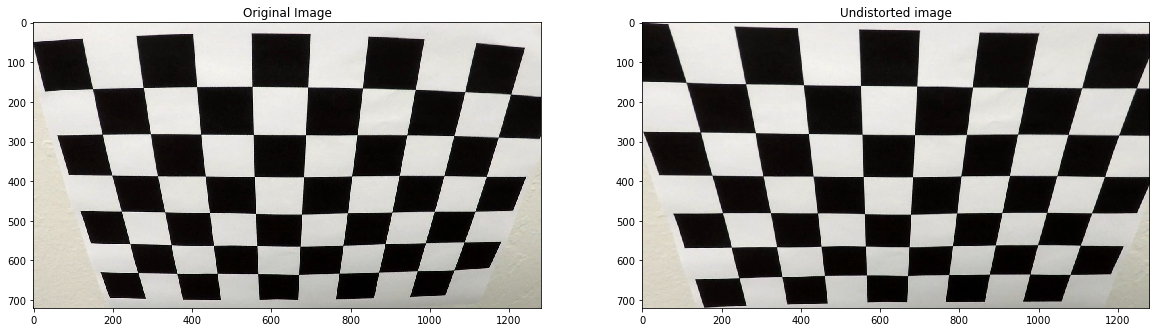

In [46]:
#show calibration and undistorted output

test_image_loc = calibration_images[11]

test_image_original = mpimg.imread(test_image_loc)
plt.figure(figsize=(20,30))
plt.subplot(121)
plt.imshow(test_image_original)
plt.title('Original Image')
undistorted_img = undistort(test_image_original, mtx,dist)
plt.subplot(122)
plt.imshow(undistorted_img)
plt.title('Undistorted image')
plt.show()


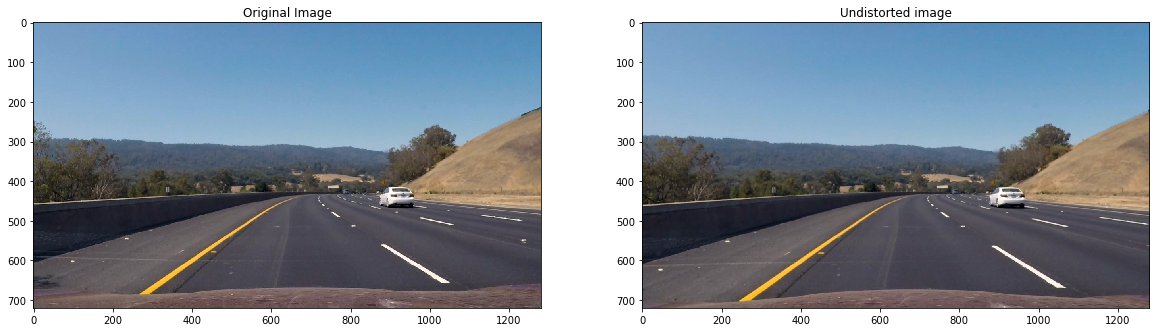

In [94]:
test_img = mpimg.imread('test_images/test3.jpg')


plt.figure(figsize=(20,30))
plt.subplot(121)
plt.imshow(test_img)
plt.title('Original Image')
undist_test_img = undistort(test_img, mtx,dist)
plt.subplot(122)
plt.imshow(undist_test_img)
plt.title('Undistorted image')
plt.show()


## Define a class to receive the characteristics of each line detection

In [15]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # recent polynomial coefficients
        self.recent_fit = []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        # counter to reset after 5 iterations if issues arise
        self.counter = 0

## Color/Gradient threshold

In [55]:
def threshold_image(img, s_thresh=(125, 255), sx_thresh=(10, 100), R_thresh = (200, 255), sobel_kernel = 3):
    """ Pipeline to create binary image.
    This version uses thresholds on the R & S color channels and Sobelx.
    Binary activation occurs where any two of the three are activated.
    """
    #distorted_img = np.copy(img)
    dst =undistort(img, mtx, dist)
    # Pull R
    R = dst[:,:,0]
    
    # Convert to HLS colorspace
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobelx - takes the derivate in x, absolute value, then rescale
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1

    # Threshold R color channel
    R_binary = np.zeros_like(R)
    R_binary[(R >= R_thresh[0]) & (R <= R_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # If two of the three are activated, activate in the binary image
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (sxbinary == 1)) | ((sxbinary == 1) & (R_binary == 1))
                     | ((s_binary == 1) & (R_binary == 1))] = 1

    return combined_binary


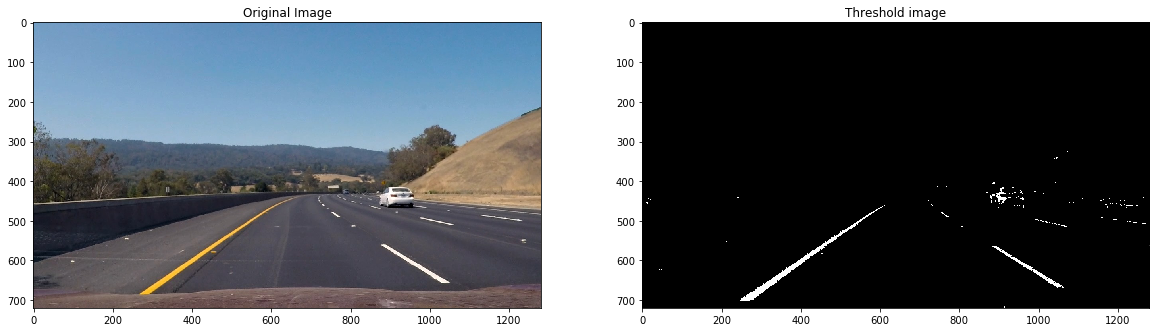

In [97]:
binary_img = threshold_image(test_img)
x = np.dstack((binary_img, binary_img, binary_img))*255

plt.figure(figsize=(20,30))
plt.subplot(121)
plt.imshow(test_img)
plt.title('Original Image')
undist_test_img = undistort(test_img, mtx,dist)
plt.subplot(122)
plt.imshow(x)
plt.title('Threshold image')
plt.show()


## Perspective Transform 

In [150]:
# define calibration box in source (orignial) and destionation (desired or warped) coordinate
img = mpimg.imread(calibration_images[0])
src_pts = np.array([[700, 450], [1160,img.shape[0]-2],[200,img.shape[0]-2], [595, 450]], np.int32)
dst_pts = np.array([[1100,0], [1100,img.shape[0]-2],[200,img.shape[0]-2], [200, 0]], np.int32)

In [89]:
# define perspective tranform function
def warp(img, src_pts, dst_pts, flag = False):
    img = np.copy(img)
    # four source coordinates
    src = src_pts.astype(np.float32)
    #four desired coordinates
    dst = dst_pts.astype(np.float32) 
    
    # compute the perspective transform matrix M for 2d images
    if flag == False:
        M = cv2.getPerspectiveTransform(src, dst)
        # create warped image using linear interpolation
        img_size = (img.shape[1], img.shape[0])
        
    # compute the perspective transform matrix M for 3d images
    elif flag == True:
        M = cv2.getPerspectiveTransform(dst, src)
        # create warped image using linear interpolation
        img_size = (img.shape[:2][1], img.shape[:2][0])
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

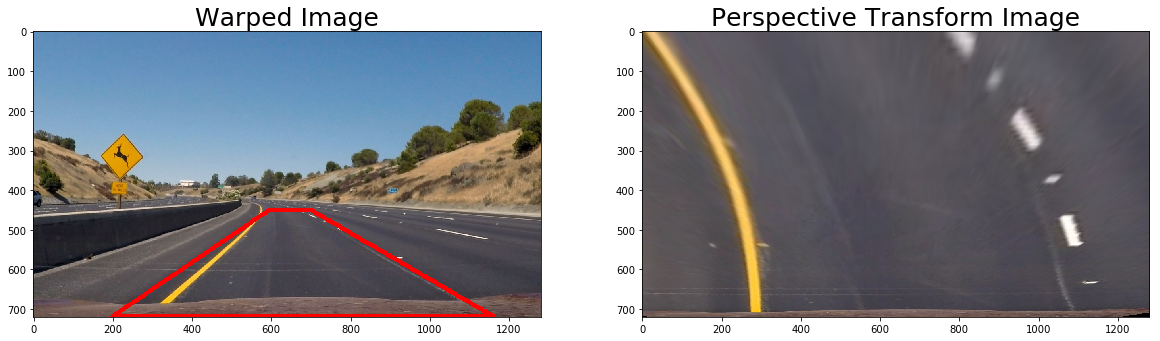

In [151]:

test_img_copy = np.copy(test_img)
warped_img = warp(test_img_copy,src_pts,dst_pts)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
cv2.polylines(test_img_copy,[src_pts],True,(255,0,0), 10)
ax1.imshow(test_img_copy)
ax1.set_title('Warped Image', fontsize=25)
ax2.imshow(warped_img, cmap='gray')
ax2.set_title("Perspective Transform Image", fontsize=25) 

#### After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. However, you still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

## Detect lane lines

In [155]:
def calculate_histogram(image):
    return np.sum(image[image.shape[0]//2:,:], axis=0)
    

In [156]:
def window_sliding(warped_im):
    
    # Take a histogram of the bottom half of the image
    histogram = calculate_histogram(warped_im)

    # This method comes from 
    # https://discussions.udacity.com/t/unable-to-draw-rectangles-on-curve-on-images/244276/61?u=jiewang
    warped_im = np.uint8(warped_im) 
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped_im, warped_im, warped_im))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint]) # np.argmax returns the indices of the maximum values along an axis
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_im.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_im.nonzero() # np.nonzero return the indices of the elements that are non-zero.
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_im.shape[0] - (window+1)*window_height
        win_y_high = warped_im.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds) # np.concatenate join a sequence of arrays along an existing axis
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, nonzerox, nonzeroy

## Fit the polynomial

In [120]:
# Generate x and y values for plotting
def poly_fit(leftx, lefty, rightx, righty, warped_im):
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx

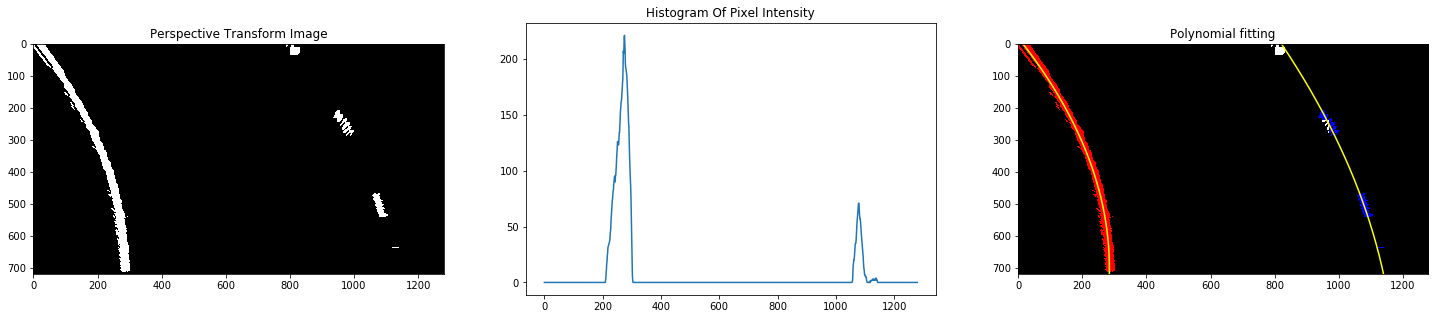

In [172]:
# Take a histogram of the bottom half of the image
test_img_copy = np.copy(test_img)
threshold_img = threshold_image(test_img_copy)
warped_img = warp(threshold_img,src_pts,dst_pts)
histogram =calculate_histogram(warped_img)

#window slide and calculate line coordinates
left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, nonzerox, nonzeroy = window_sliding(warped_img)
# polynomial fitting 
left_fit, right_fit, left_fitx, right_fitx = poly_fit(leftx, lefty, rightx, righty, warped_img)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
  
out_img = np.dstack((warped_img, warped_img, warped_img))*255

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


fig, ax = plt.subplots(1, 3, figsize=(25,5))
ax[0].imshow(warped_img, cmap='gray')
ax[0].set_title("Perspective Transform Image")
ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensity")
ax[2].imshow(out_img)
ax[2].plot(left_fitx, ploty, color='yellow')
ax[2].plot(right_fitx, ploty, color='yellow')
ax[2].set_title("Polynomial fitting")
plt.show()

## Lane curvature calculation

In [121]:
def car_movement(left_fitx, right_fitx, warped_im):
    
    # Define conversions in x and y from pixels space to meters
    # read the description carefully how to conduct this:
    # https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/2f928913-21f6-4611-9055-01744acc344f
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension
    
    ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0] )
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # average radius of curvature is in meters
    rad_curverad = (left_curverad + right_curverad)/2
    
    # calculate the car offset
    line_ave = (left_fitx[-1] + right_fitx[-1])/2
    line_offset = line_ave - (warped_im.shape[1]//2)
    car_offset = line_offset * xm_per_pix
    
    return rad_curverad, car_offset

## Draw on a frame

In [122]:
def draw_lines(warped_im, undist_test_imgs, left_fitx, right_fitx):
    
    ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0] )

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_im).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp =  warp(color_warp, src_pts, dst_pts, flag = True)
    # Combine the result with the original image
    fix_img = cv2.addWeighted(undist_test_imgs, 1, newwarp, 0.3, 0)
    rad_curverad, car_offset = car_movement(left_fitx, right_fitx, warped_im)
    
    car_offset = 'Car Offset: ' + '{0:.2f}'.format(car_offset) + 'm'
    rad_curverad = 'Curvature Radius:' + '{0:.2f}'.format(rad_curverad) + 'm'
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(fix_img, car_offset, (10,50), font, 1,(255,255,255),2)
    cv2.putText(fix_img, rad_curverad, (10,100), font, 1,(255,255,255),2)
    
    #cv2.putText(fix_img, car_offset , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=2)
    #cv2.putText(fix_img, rad_curverad , (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=2)
    
    return fix_img

## Video pipeline

In [124]:
def video_pipeline(img):
    
    #color and gradient thresholding image,warp the images, detect lane lines, fit polynomial and draw lines
    combined_bin = threshold_image(img)
    warped_im = warp(combined_bin, src_pts, dst_pts, flag = False)
    
    # windows sliding line searching 
    left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, nonzerox, nonzeroy = window_sliding(warped_im)
    # polynomial fitting 
    left_fit, right_fit, left_fitx, right_fitx = poly_fit(leftx, lefty, rightx, righty, warped_im)
    # line drawing
    fixed_img = draw_lines(warped_im, img, left_fitx, right_fitx)
    
    return fixed_img


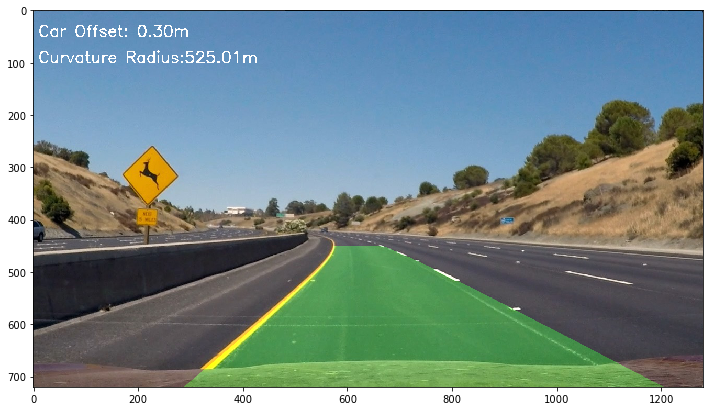

In [182]:
import matplotlib.image as mpimg
test_img = mpimg.imread('test_images/test2.jpg')
image = video_pipeline(test_img)

width = 12
height = 12
plt.figure(figsize=(width, height))

plt.imshow(image)




In [185]:
src_pts
dst_pts

array([[1100,    0],
       [1100,  718],
       [ 200,  718],
       [ 200,    0]])

In [162]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

counter = 0
output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")

output_clip = clip1.fl_image(video_pipeline) 
%time output_clip.write_videofile(output, audio=False)

print(counter)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:47<00:00,  6.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 2min 48s
0
